In [26]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import KFold
import pickle
import os

model_loc = "./Dataset/dtree_20_images.sav"

In [27]:
skin_dataset = pd.read_csv("./Dataset/pixelwise_skin_and_burn_20_images.csv")
skin_dataset = skin_dataset.dropna()
X = skin_dataset.iloc[:,:-1]
y = skin_dataset.iloc[:,-1]

In [28]:
is_NaN = X.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X[row_has_NaN]

print(rows_with_NaN)
print(len(rows_with_NaN))

Empty DataFrame
Columns: [h, s, i]
Index: []
0


In [29]:
model_scores = []
models = []
fold_num = 0
kf =KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    fold_num += 1
    print("Fold:", fold_num)
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #print(X_train)
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]# split()  method generate indices to split data into training and test set.
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train.values, y_train.values)
    score = clf.score(X_test.values, y_test.values)
    models.append(clf)
    model_scores.append(score)

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10


In [30]:
print(len(models))
print(model_scores)
max_value = max(model_scores)
max_index = model_scores.index(max_value)
pickle.dump(models[max_index], open(model_loc, 'wb'))
#print(len(models))

10
[0.9053347280334728, 0.9038932677573567, 0.9056091316994394, 0.9048291935439472, 0.905012708404063, 0.9059669856766651, 0.9057926465595552, 0.9062055549948157, 0.9047741390859125, 0.9045997999688025]


In [31]:
loaded_model = pickle.load(open(model_loc, 'rb'))
print("Loaded Model is:", model_loc)

Loaded Model is: ./Dataset/dtree_20_images.sav


In [32]:
test_img = "./Dataset/full_coco/images/img1.jpg"
from skin_segmentation import load_rgb_image
from converter import RGB_TO_HSI
import numpy as np

def segment_image(rgb_image):
    test_image_data = rgb_image.copy()
    test_image_hsi = RGB_TO_HSI(test_image_data)
    for row in range(0, test_image_hsi.shape[1]):
        for col in range(0, test_image_hsi.shape[0]):
            if np.isnan(test_image_hsi[row,col][0]):
                test_image_data[row,col] = (0, 0, 0)
                continue
            else:
                prediction = loaded_model.predict([test_image_hsi[row,col]])
                if prediction == 0:
                    test_image_data[row,col] = (0, 0, 0)
                elif prediction == 1:
                    test_image_data[row,col] = (125, 125, 125)
                elif prediction == 2:
                    test_image_data[row,col] = (250, 250, 250)
    return test_image_data

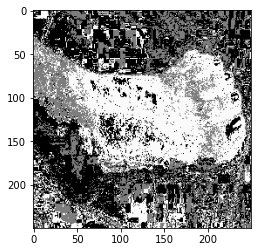

In [33]:
import matplotlib.pyplot as plt

rgb_image = load_rgb_image(test_img)
segmented_image = segment_image(rgb_image)
plt.imshow(segmented_image)
